# Airbnb Property Listing - Classification Modelling with Numerical Data

## Library Imports

In [34]:
import pandas as pd
import numpy as np

from zipfile import ZipFile
import data_cleaning

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, accuracy_score

## Import Data

In [2]:
with ZipFile('./airbnb-property-listings.zip') as myzip:
    data = myzip.open("AirbnbDataSci/tabular_data/AirBnbData.csv")

data_df = pd.read_csv(data)
cleaned_data_df = data_df.pipe(data_cleaning.clean_tabular_data)
cleaned_data_df.head()

,id,category,title,description,amenities,location,guests,beds,bathrooms,price_night,cleanliness_rate,accuracy_rate,communication_rate,location_rate,check-in_rate,value_rate,amenities_count,url,bedrooms
0,f9dcbd09-32ac-41d9-a0b1-fdb2793378cf,Treehouses,Red Kite Tree Tent - Ynys Affalon,Escape to one of these two fabulous Tree Tents...,"['What this place offers', 'Bathroom', 'Shampo...",Llandrindod Wells United Kingdom,2.0,1.0,1.0,105.0,4.6,4.7,4.3,5.0,4.3,4.3,13.0,https://www.airbnb.co.uk/rooms/26620994?adults...,1.0
1,1b4736a7-e73e-45bc-a9b5-d3e7fcf652fd,Treehouses,Az Alom Cabin - Treehouse Tree to Nature Cabin,Come and spend a romantic stay with a couple o...,"['What this place offers', 'Bedroom and laundr...",Guyonvelle Grand Est France,3.0,3.0,0.0,92.0,4.3,4.7,4.6,4.9,4.7,4.5,8.0,https://www.airbnb.co.uk/rooms/27055498?adults...,1.0
2,d577bc30-2222-4bef-a35e-a9825642aec4,Treehouses,Cabane Entre Les Pins\n🌲🏕️🌲,"Rustic cabin between the pines, 3 meters high ...","['What this place offers', 'Scenic views', 'Ga...",Duclair Normandie France,4.0,2.0,1.5,52.0,4.2,4.6,4.8,4.8,4.8,4.7,51.0,https://www.airbnb.co.uk/rooms/51427108?adults...,1.0
3,ca9cbfd4-7798-4e8d-8c17-d5a64fba0abc,Treehouses,Tree Top Cabin with log burner & private hot tub,The Tree top cabin is situated in our peaceful...,"['What this place offers', 'Bathroom', 'Hot wa...",Barmouth Wales United Kingdom,2.0,1.0,1.0,132.0,4.8,4.9,4.9,4.9,5.0,4.6,23.0,https://www.airbnb.co.uk/rooms/49543851?adults...,1.0
5,cfe479b9-c8f8-44af-9bc6-46ede9f14bb5,Treehouses,Treehouse near Paris Disney,"Charming cabin nestled in the leaves, real unu...","['What this place offers', 'Bathroom', 'Hair d...",Le Plessis-Feu-Aussoux Île-de-France France,4.0,3.0,1.0,143.0,5.0,4.9,5.0,4.7,5.0,4.7,32.0,https://www.airbnb.co.uk/rooms/935398?adults=1...,2.0


In [3]:
cleaned_data_df.isna().sum().sum()

0

## Baseline Model
Model to predict the category column from the numerical data only

In [6]:
# Split the data into data X and label y
X = cleaned_data_df.select_dtypes('number')
y = cleaned_data_df.category
y.dtype

CategoricalDtype(categories=['Amazing pools', 'Beachfront', 'Chalets', 'Offbeat',
                  'Treehouses'],
, ordered=False)

In [10]:
# Split the data into train/test making sure to stratify the split so the test data is representative
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

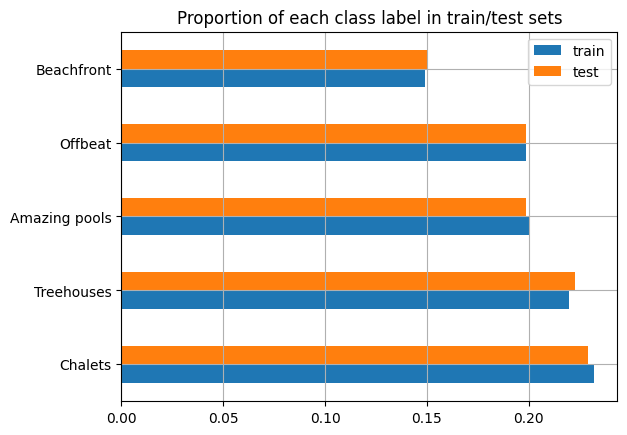

In [17]:
# Plot the proportions of each class label in the train/test data
samples_train_test_df = pd.DataFrame({'train': y_train.value_counts()/y_train.count(), 'test': y_test.value_counts()/y_test.count()})
samples_train_test_df.plot.barh(grid=True, title='Proportion of each class label in train/test sets');

In [36]:
# get a baseline score with logistic regression
train_scores = np.zeros(5,)
valid_scores = np.zeros(5,)
train_accuracy = np.zeros(5,)
valid_accuracy = np.zeros(5,)

skf = StratifiedKFold()
for fold_i, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    train_data = X_train.values[train_idx]
    valid_data = X_train.values[valid_idx]
    train_label = y_train.values[train_idx]
    valid_label = y_train.values[valid_idx]

    std_scl = StandardScaler()
    train_data_scaled = std_scl.fit_transform(train_data)
    valid_data_scaled = std_scl.transform(valid_data)

    clf_mdl = LogisticRegression(max_iter=100 ,random_state=42, solver='liblinear')
    clf_mdl.fit(train_data, train_label)

    y_train_pred_prob = clf_mdl.predict_proba(train_data_scaled)
    y_valid_pred_prob = clf_mdl.predict_proba(valid_data_scaled)

    y_train_pred = clf_mdl.predict(train_data_scaled)
    y_valid_pred = clf_mdl.predict(valid_data_scaled)

    train_scores[fold_i] = log_loss(train_label, y_train_pred_prob)
    valid_scores[fold_i] = log_loss(valid_label, y_valid_pred_prob)

    train_accuracy[fold_i] = accuracy_score(train_label, y_train_pred)
    valid_accuracy[fold_i] = accuracy_score(valid_label, y_valid_pred)

print(f'Mean training loss:\t{np.mean(train_scores):.4f}')
print(f'Mean validation loss:\t{np.mean(valid_scores):.4f}\n')
print(f'Mean training accuracy:\t\t {np.mean(train_accuracy):.4f}')
print(f'Mean validation accuracy:\t {np.mean(valid_accuracy):.4f}')

Mean training loss:	1.5365
Mean validation loss:	1.6122

Mean training accuracy:		 0.2948
Mean validation accuracy:	 0.2501


In [61]:
train_data_class_ratio = y_train.value_counts().sort_index().div(y_train.count()).values
# np.tile(train_data_class_ratio, (10,1)).shape
# y_train.values.shape, np.tile(train_data_class_ratio, len(y_train)).shape
log_loss_random = log_loss(y_train.values, np.tile(train_data_class_ratio, (len(y_train),1) ))
print(f'Log Loss of the raw distribution of the training data: {log_loss_random:.4f}')

Log Loss of the raw distribution of the training data: 1.5989


Ok, so not a great start as so far have got a model that performs worse than random.